In [73]:
%run talktools.py #run this cell first!

# Intermediate Python Workshop
Physics and Astronomy ULAB, Spring 2019

## Introduction

Over the next hour or so, we'll be working through a fun problem to make evident a few tips, tricks, and tools that make a research workflow much more smooth. The problem we'll be working on is related to the [Transiting Exoplanet Survey Satellite](https://tess.mit.edu/) — more succinctly known as TESS. Hopefully, you'll be able to reference some of the methods we use here in your future projects!

<img src='img/tess.jpg' width=700 height=700></img>
Source: NASA

### The goal
In essence, what we'll be doing is calculating the periods of all the planet candidates that TESS has produced and comparing our calculations to the estimates that the TESS team provides. In the process, we'll use a variety of fun tools!

Technical caveat: we'll only be accessing the candidates with designated Target Pixel Files (TPFs); I haven't written anything to look at the full-frame images (FFIs) yet.

### A brief overview of the science involved

Before we dive into the coding, it's important that we understand a bit about the background science. Thankfully, transits are a very physical concept, and thus I find that interpreting the relevant data is somewhat intuitive. Essentially, if we're looking at a planet orbit a star edge-on, from our perspective the planet will block some of its host star's light at some point during the orbit. When this happens, we can measure how much less light we're receiving from the star. In general, for a given star, the larger the planet, the more light it blocks — or, to use more technical terms, the stronger the transit signal.

<img src='img/transit.jpg' width=700 height=700></img>
Source: ESA

If we see a planet transit its host star multiple times, we can calculate the period of its orbit. One common way to do this in practice is by using the [Box Least Squares algorithm](https://arxiv.org/pdf/astro-ph/0206099.pdf) (Kovacs et. al 2002). The algorithm essentially models the transit as a small box, slides it over the light curve, and minimizes the error. And with that, let's dive right into it!

## Dependencies
The first thing we need to do is make sure that we all have the requisite packages.

In [11]:
!pip install lightkurve
!pip install line_profiler
!pip install ipdb

    100% |████████████████████████████████| 92kB 1.8MB/s ta 0:00:011
  Running setup.py bdist_wheel for line-profiler ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/05/7d/9b/aafbe8d78dc2b2c644d2efd2f060ab3258143860142575193a
Successfully built line-profiler


Now we make our imports. 

In [70]:
from IPython.display import display
from ipywidgets import IntProgress
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy.f2py as f2py
import numpy as np
import pandas as pd
import lightkurve
import pickle
import ipdb
import os

from line_profiler import LineProfiler
from scipy.stats import gaussian_kde
from urllib.request import urlretrieve
from urllib.parse import urlencode
from urllib.request import urlopen

## Using f2py
As it turns out, BLS is often implemented in Fortran, as Python is quite slow by comparison. Check out the file ```eebls.f``` to get a sense of how Fortran code looks. The only thing that matters to us here is that the Fortran analogue of a function is a subroutine.

We can use numpy's handy [f2py](https://docs.scipy.org/doc/numpy/f2py/) module to solve that for us, though — we can essentially treat the entire code as a black box. If f2py works, it'll output ```0``` after it's done running. Once it's done, we can import the module as normal.

In [13]:
os.system("f2py -c -m eebls eebls.f")

0

In [14]:
import eebls

In [15]:
def do_bls(clipped_lc):
    '''Takes in a lightcurve object, runs the Fortran BLS implementation, and returns the computed best period.'''
    maxper = 20 #maximum orbital period in days
    minper = 1 #minimum orbital period in days
    maxdurhr = 6 #hours
    mindurhr = 0.5 #hours
    npoints = len(clipped_lc.time)
    u = np.zeros(npoints) #empty work array
    v = np.zeros(npoints) #empty work array
    fmin = 1/maxper #minimum frequency considered
    fmax = 1/minper #maximum frequency considered
    qmi = mindurhr/(24.*maxper) #shortest fractional duration considred
    qma= np.min([0.1,maxdurhr/(24.*maxper)]) #longest fractional duration considred
    nb = 500 #sets the number of bins used at each orbital period; 
    df = 0.0005 #frequency spacing
    nf = np.int((fmax - fmin)/df) #number of frequencies considered
    results = eebls.eebls(np.array(clipped_lc.time), np.array(clipped_lc.flux), u, v, nf, fmin, df, nb, qmi, qma)
    power, best_period, best_power, depth, q, in1, in2 = results    
    f = fmin + np.arange(nf) * df #frequencies used
    per_used = 1/f
    return best_period

Quick reminder to always write docstrings for your functions! You can use the ```help``` function to debug later on.

In [16]:
help(do_bls)

Help on function do_bls in module __main__:

do_bls(clipped_lc)
    Takes in a lightcurve object, runs the Fortran BLS implementation, and returns the computed best period.



Read the below function, figure out what it does, and write a succint docstring.

In [17]:
def mask(flat_lc):
    global_mean = np.mean(flat_lc.flux)
    global_variance = np.var(flat_lc.flux)
    sample_means = []
    sample_variances = []
    bins = 10
    bin_indices = np.linspace(0, len(flat_lc.flux), bins).astype(np.int)
    for i in range(bins - 1):
        sample = flat_lc.flux[bin_indices[i]:bin_indices[i + 1]]
        sample_means += [np.mean(sample)]
        sample_variances += [np.var(sample)]

    m = 1.5
    sample_variances = np.array(sample_variances)
    bad_bins = np.argwhere(np.abs(sample_variances - np.mean(sample_variances)) > m * np.std(sample_variances))
    bad_indices = [(bin_indices[bad_bin[0]], bin_indices[bad_bin[0] + 1]) for bad_bin in bad_bins]
    bad_times = [(flat_lc.time[index[0]], flat_lc.time[index[1] - 1]) for index in bad_indices]
    for time in bad_times:
        mask = (flat_lc.time < time[0]) | (flat_lc.time > time[1])
        flat_lc = flat_lc[mask]
    return flat_lc

## A brief foray into visualization
Edit the below function to spit out the ```lc``` object. What is its type? How can we best visualize it? Hint: find the ```lightkurve``` documentation.

In [37]:
def period_from_url(url):
    '''Takes in a URL, reads in the relevant TargetPixelFile, masks it, and runs BLS on it.'''
    tpf = lightkurve.TessTargetPixelFile('https://archive.stsci.edu' + url)
#     sectors += [tpf.sector]
#     cameras += [tpf.camera]
#     ccds += [tpf.ccds]
    median_image = np.nanmedian(tpf.flux, axis=0)
    aperture_mask = median_image > np.nanpercentile(median_image, 85)
    lc = tpf.to_lightcurve(aperture_mask=aperture_mask)
    flat_lc = lc.flatten(window_length=1001)
#     flat_lc = flat_lc.flux
#     ipdb.set_trace()
    masked_lc = mask(flat_lc)
    clipped_lc = masked_lc.remove_outliers(sigma=6)
    best_period = do_bls(clipped_lc)
    return tpf.targetid, best_period

## A brief foray into web scraping
Using Python to scrape the internet is one of the coolest things you can do! You literally have *the world* at your fingertips. Edit the below code to see what ```string```, ```strings```, and ```URLs``` look like. Discuss the quality of these variable names.

The below code is an example of using Jupyter Notebooks as an exploratory tool — instead of writing functions, I just have open code (a "flat" architecture) that I'm using interactively. The benefit of this technique is that it's a quick and dirty way to check whether a method works, and it's easy to write. On the flip side, it's sometimes harder for others to read/debug if your whole notebook is like this (remember docstrings?), and you'll end up with a bunch of variables set out of order all over the place.

In [42]:
targetids = []
sectors = []
cameras = []
periods = []
urlpath = urlopen(f'https://archive.stsci.edu/prepds/tess-data-alerts/')
string = urlpath.read().decode('utf-8')
strings = string.split('>')
URLs = [url[9:-1] for url in strings if url[-8:-1] == 'tp.fits']

    
f = IntProgress(min=0, max=len(URLs)) # instantiate the progress bar
display(f) # display the progress bar

for url in URLs:
    f.value += 1
    targetid, best_period = period_from_url(url)
    periods += [best_period] 
    targetids += [targetid]

## A brief foray into debugging
This is taking a pretty long time to run! Let's see if we can figure out why. Try to avoid inserting ```print``` statements ad hoc!

The first thing to do is insert a trace with [ipdb](https://pypi.org/project/ipdb/). We can simply use ```ipdb.set_trace()``` to do so. When we set a trace, we can essentially interact with any of te variables while a function is mid-execution! Type ```c``` to move past the trace.

In [38]:
 period_from_url(URLs[0])

(2760710, 15.625)

The next thing we can do is see if we can speed some things up. We can try something called multiprocessing to do so — this allows us to make use of Datahub's multiple cores. In order to see how fast the speedup is, we can use a profiler. [line_profiler](https://github.com/rkern/line_profiler), in fact. It is my favorite piece of code in the world.

First, we need to turn the above code block into a function. Have the function take in one argument (how many URLs to evaluate), and have it return two lists: ```periods``` and ```targetids```.

In [52]:
lp = LineProfiler() #instantiate the profiler
lp.add_function(period_from_url) #add any functions nested in the main
lp_wrapper = lp(many_URLs) #call this on the main function
lp_wrapper(30) #this is basically you calling your function on an argument
lp.print_stats() #witness beauty!

IntProgress(value=0, max=30)

Timer unit: 1e-06 s

Total time: 22.7273 s
File: <ipython-input-37-f69a4f629a4e>
Function: period_from_url at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def period_from_url(url):
     2                                               '''Takes in a URL, reads in the relevant TargetPixelFile, masks it, and runs BLS on it.'''
     3        30    8556027.0 285200.9     37.6      tpf = lightkurve.TessTargetPixelFile('https://archive.stsci.edu' + url)
     4                                           #     sectors += [tpf.sector]
     5                                           #     cameras += [tpf.camera]
     6                                           #     ccds += [tpf.ccds]
     7        30    2717404.0  90580.1     12.0      median_image = np.nanmedian(tpf.flux, axis=0)
     8        30      10483.0    349.4      0.0      aperture_mask = median_image > np.nanpercentile(median_image, 85)
     9        30    23154

In [53]:
lp = LineProfiler() #instantiate the profiler
lp_wrapper = lp(multiprocess) #call this on the main function
lp_wrapper(20) #this is basically you calling your function on an argument
lp.print_stats() #witness beauty!

Number of processors:  8
20
Timer unit: 1e-06 s

Total time: 6.23871 s
File: <ipython-input-50-aa352213c077>
Function: multiprocess at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def multiprocess(length):
     2         1     177818.0 177818.0      2.9      urlpath = urlopen(f'https://archive.stsci.edu/prepds/tess-data-alerts/')
     3         1     606411.0 606411.0      9.7      string = urlpath.read().decode('utf-8')
     4         1       1946.0   1946.0      0.0      strings = string.split('>')
     5         1       5625.0   5625.0      0.1      URLs = [url[9:-1] for url in strings if url[-8:-1] == 'tp.fits']
     6         1        770.0    770.0      0.0      print("Number of processors: ", mp.cpu_count()) #using all the processors on Datahub makes it crash :/
     7         1     409733.0 409733.0      6.6      pool = mp.Pool(5)
     8                                           
     9                  

In [74]:
def multiprocess(length):
    '''Uses multiprocessing to speed up the period computation. Takes in the length of URLs that you'd 
    like to evaluate, and returns a list of tuples; the first element in each tuple corresponds to the target ID,
    and the second element in each tuple corresponds to that target's calculated period.'''
    urlpath = urlopen(f'https://archive.stsci.edu/prepds/tess-data-alerts/')
    string = urlpath.read().decode('utf-8')
    strings = string.split('>')
    URLs = [url[9:-1] for url in strings if url[-8:-1] == 'tp.fits']
    print("Number of processors: ", mp.cpu_count()) #using all the processors on Datahub makes it crash :/
    pool = mp.Pool(5)

    # Step 2: `pool.apply` the function!`
    results = pool.map(period_from_url, [url for url in URLs][:length])

    # Step 3: Don't forget to close
    pool.close()    
    print(len(results))
    return results

## A brief foray into pickles
The above process will still take a while for all the available TESS data. Instead of twiddling our thumbs while we wait for it all to run, we can just read in the results of a previous session I ran.

[Pickling](https://docs.python.org/3/library/pickle.html) is a great way to store Python objects. Instead of figuring out how to format your Python object so you can write it to and later read it from a text file or CSV, you just "dump" your object into a .pkl file. It is brilliant. 

In [71]:
#this is the syntax for dumping — no need to run this cell!
with open('periods.pkl', 'wb') as f:
    pickle.dump(periods, f)
    
with open('targetids.pkl', 'wb') as f:
    pickle.dump(targetids, f)

In [72]:
file = open('periods.pkl', 'rb')
periods= pickle.load(file)
# close the file
file.close()

file = open('targetids.pkl', 'rb')
targetids = pickle.load(file)
# close the file
file.close()

## A brief foray into pandas & more visualization
[Pandas](https://pandas.pydata.org/) is a great way to handle a bunch of data. You can organize arrays into columns and just slice the specific data you need. I'm a big fan of it, and it's used quite ubiquitously. In addition, you can also easily write to/read from Excel files and CSVs. One of the coolest things you can do, though, is read directly from an html file!

Check out ```big_frame```. How messy is it? Produce a list of the columns.

Next, calculate some stats for ```calc_no_dup```.

In [54]:
big_frame = pd.read_html('https://archive.stsci.edu/prepds/tess-data-alerts/')
calc_frame = pd.DataFrame({'TIC ID': targetids, 'Period':periods})

In [55]:
tic = big_frame[0][big_frame[0].columns[0][0]].squeeze().values
toi = big_frame[0][big_frame[0].columns[1][0]].squeeze().values
period = big_frame[0][big_frame[0].columns[4][0]].squeeze().values
epoch = big_frame[0][big_frame[0].columns[5][0]].squeeze().values

true_frame = pd.DataFrame({'TIC ID': tic, 'TOI ID': toi, 'Period':period, 'Epoch':epoch})
true_frame = true_frame.drop_duplicates('TIC ID')

not_nan = np.isfinite(true_frame['TIC ID']) & np.isfinite(true_frame['Period'])
relevant_t = true_frame['TIC ID'].isin(calc_frame['TIC ID'].values) #question: same order?
relevant_trues = true_frame[relevant_t & not_nan]

relevant_c = calc_frame['TIC ID'].isin(relevant_trues['TIC ID'].values)
calc_frame = calc_frame[relevant_c]

calc_no_dup = calc_frame.drop_duplicates('TIC ID').reset_index(drop=True)


for i in range(len(calc_no_dup)):
    sub = calc_frame[calc_frame['TIC ID'] == calc_no_dup['TIC ID'][i]]
    mean_period = np.mean(sub['Period'])
    calc_no_dup.loc[i, 'Period'] = mean_period
#for duplicates I'm taking the average — just a start

In [68]:
#labels here being truths
def calc_stats(data, truths):
    '''Inputs are an array-like object with calculated values and an array-like object with true values.
    Returns bias and root-mean-squared scatter.'''
    bias = np.mean((np.array([a - b for a,b in zip(data, truths)])))
    RMS_array = (np.array([pow(a - b, 2) for a,b in zip(data,truths)]))
    RMS = np.sqrt((1/len(RMS_array))*np.sum(RMS_array))
    return bias, RMS

You'll notice that our plot doesn't look very good. Discuss with your neighbor why this might be the case.

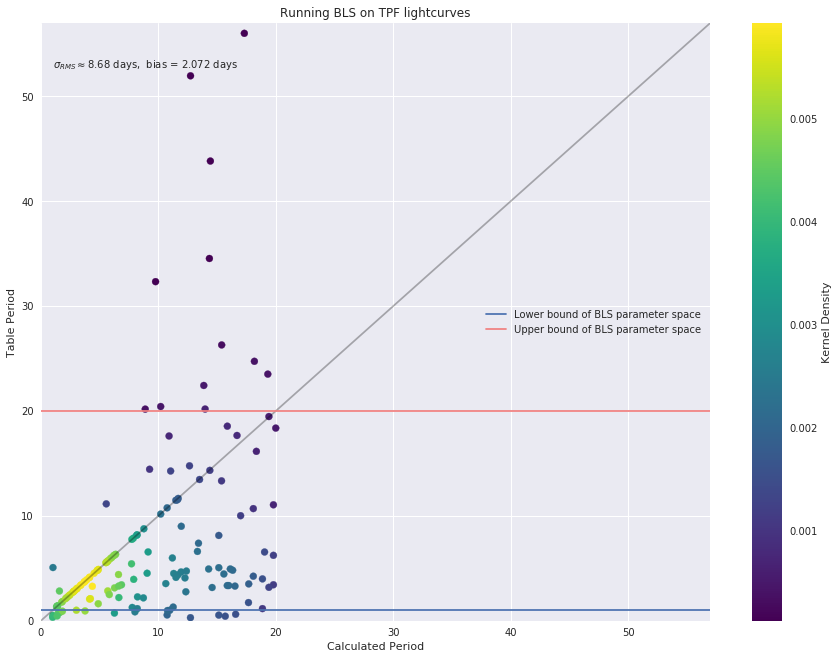

In [67]:
max_point = max(np.max(calc_frame['Period']), np.max(relevant_trues['Period']))

xy = np.vstack([calc_no_dup['Period'], relevant_trues['Period']]) 
z = gaussian_kde(xy)(xy) #calculates how dense a certain scatter region is

x = np.linspace(0, max_point + 1, 100)

bias, RMS = calc_stats(calc_no_dup['Period'], relevant_trues['Period'])

plt.style.use('seaborn') #a nice styling!
plt.figure(figsize=(15,11)) #make the size of the plot
plt.scatter(calc_no_dup['Period'], relevant_trues['Period'], c=z, cmap='viridis', label='')
plt.plot(x,x,color='black', alpha=.3)
plt.xlim(0, max_point + 1)
plt.ylim(0, max_point + 1)
plt.colorbar(label="Kernel Density")
plt.text(1, max_point - 3, r'$\sigma_{RMS} \approx $' + f"{round(RMS,3)} days, \
 bias = {round(bias,3)} days",
         horizontalalignment='left',
         verticalalignment='center',
         clip_on=False)
plt.xlabel('Calculated Period')
plt.axhline(y=1, label='Lower bound of BLS parameter space')
plt.axhline(y=20, color='lightcoral', label='Upper bound of BLS parameter space')
plt.ylabel('Table Period')
plt.title('Running BLS on TPF lightcurves')
plt.legend()